In [1]:
import os
import random

import pickle
import numpy as np
import scipy.io as spio
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.colors as mcolors
import tensorflow as tf

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from matplotlib.ticker import ScalarFormatter, FormatStrFormatter, MaxNLocator


custom_seed = 42
np.random.seed(custom_seed)
tf.random.set_seed(custom_seed)

In [2]:
tf.config.set_visible_devices([], 'GPU')

In [3]:
problem = "nonlinear_problem_P4"

In [4]:
data_folder = os.path.abspath(os.path.join(os.getcwd(), '../../../data'))
results_folder = os.path.abspath(os.path.join(os.getcwd(), f'../../../results/{problem}_results'))

# print(data_folder)
# print(results_folder)

In [5]:
data_path = os.path.join(data_folder, f'{problem}_data.pkl')
first_training_result_path = os.path.join(results_folder, f'{problem}_first_train.pkl')
second_training_result_path = os.path.join(results_folder, f'{problem}_new_train.pkl')

# print(data_path)
# print(first_training_result_path)
# print(second_training_result_path)

In [6]:
# Load data
with open(data_path, 'rb') as f:
    data = pickle.load(f)

# Load first training
with open(first_training_result_path, 'rb') as f:
    results_first_train_pkl = pickle.load(f)

results_first_train = results_first_train_pkl['training']
predictions_predictive_first_train = results_first_train_pkl['predictions_pred']
predictions_explanatory_first_train = results_first_train_pkl['predictions_exp']

# Load second training
with open(second_training_result_path, 'rb') as f:
    results_second_train_pkl = pickle.load(f)

results_second_train = results_second_train_pkl['training']
predictions_predictive_second_train = results_second_train_pkl['predictions_pred']
predictions_explanatory_second_train = results_second_train_pkl['predictions_exp']

In [7]:
n_data = data['n_data']
n_discretization = data['n_discretization']
x_step_size = data['x_step_size']
y_step_size = data['y_step_size']

Functions that are necessary 

In [8]:
# Finite difference convolutional operator to derivate in x axis
def Dx(f, x_step_size=x_step_size):
    Dx = tf.constant([[-1, +1], 
                      [-1, +1]], 
                     dtype=tf.float32)/(2*x_step_size)

    f_reshaped = tf.expand_dims(f[:, :, :], axis=-1)    
    Dx = tf.expand_dims(tf.expand_dims(Dx, axis=-1), axis=-1)
    dfdx = tf.nn.conv2d(f_reshaped, Dx, strides=[1, 1, 1, 1], padding='VALID', name='dfdx')
    return tf.squeeze(dfdx, axis=-1)

# Finite difference convolutional operator to derivate in y axis
def Dy(f, y_step_size=y_step_size):
    Dy = tf.constant([[+1, +1], 
                      [-1, -1]],  
                     dtype=tf.float32)/(-2*y_step_size)

    f_reshaped = tf.expand_dims(f[:, :, :], axis=-1)    
    Dy = tf.expand_dims(tf.expand_dims(Dy, axis=-1), axis=-1)
    dfdy = tf.nn.conv2d(f_reshaped, Dy, strides=[1, 1, 1, 1], padding='VALID', name='dfdy')
    return tf.squeeze(dfdy, axis=-1)

# Convolutional operator to do the mean between two elements of a mesh in x axis
def Mx(f):
    Mx = tf.constant([[+1, +1]], 
                     dtype=tf.float32)/(2)

    f_reshaped = tf.expand_dims(f[:, :, :], axis=-1)    
    Mx = tf.expand_dims(tf.expand_dims(Mx, axis=-1), axis=-1)
    x_avg = tf.nn.conv2d(f_reshaped, Mx, strides=[1, 1, 1, 1], padding='VALID', name='Mx')
    return tf.squeeze(x_avg, axis=-1)

# Convolutional operator to do the mean between two elements of a mesh in y axis
def My(f):
    My = tf.constant([[+1], 
                      [+1]], 
                     dtype=tf.float32)/(2)

    f_reshaped = tf.expand_dims(f[:, :, :], axis=-1)    
    My = tf.expand_dims(tf.expand_dims(My, axis=-1), axis=-1)
    y_avg = tf.nn.conv2d(f_reshaped, My, strides=[1, 1, 1, 1], padding='VALID', name='My')
    return tf.squeeze(y_avg, axis=-1)

In [9]:
def smooth_curve(data, window_size=50):
    window = np.ones(window_size) / window_size
    return np.convolve(data, window, mode='valid')

def cm_to_in(cm):
    return cm * 0.393701

def normalize_list(lst):
    max_value = max(lst)
    return [x / max_value for x in lst]

Graphics parameters

In [10]:
linewidth = 1.5
title_fontsize = 14
label_fontsize = 14
legend_fontsize = 12
tick_fontsize = 11

# plt.rc('text', usetex=True)
plt.rc('font', family='serif')

posX = cm_to_in(10)
posY = cm_to_in(10)
width = cm_to_in(16)
height = cm_to_in(8)

color = [0.1, 0, 0.8]
subplot_adjust_left = cm_to_in(0.15)
subplot_adjust_bottom = cm_to_in(0.15)

In [11]:
if problem == "nonlinear_problem_P3":
    training_curves_color = 'black'

elif problem == "nonlinear_problem_P4":
    training_curves_color = 'green'

else:
    training_curves_color = 'blue'

Training curves

In [12]:
train_total_loss_list = results_first_train['train_total_loss_list'] + results_second_train['train_total_loss_list']
test_total_loss_list = results_first_train['test_total_loss_list'] + results_second_train['test_total_loss_list']

train_total_MSE_list = results_first_train['train_total_MSE_list'] + results_second_train['train_total_MSE_list']
test_total_MSE_list = results_first_train['test_total_MSE_list'] + results_second_train['test_total_MSE_list']

In [13]:
# This step will be done if data haven't been normalized when results are beeing saved after each training iteration
N_val = data['X_val'].shape[0]
N_batch = 64

train_total_loss_list = [x / N_batch for x in train_total_loss_list]
test_total_loss_list = [x / N_val for x in test_total_loss_list]

train_total_MSE_list = [x / N_batch for x in train_total_MSE_list]
test_total_MSE_list = [x / N_val for x in test_total_MSE_list]

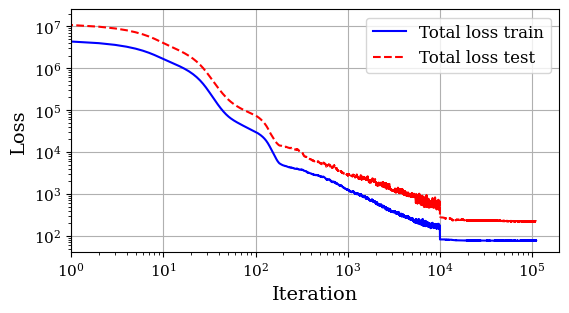

In [14]:
plt.figure(figsize=(width, height))

plt.plot(smooth_curve(train_total_loss_list), label='Total loss train', color='blue', linestyle='-')
plt.plot(smooth_curve(test_total_loss_list), label='Total loss test', color='red', linestyle='--')

plt.xlabel('Iteration', fontsize=label_fontsize)
plt.ylabel('Loss', fontsize=label_fontsize)

plt.grid(True)
plt.legend(loc='upper right', fontsize=legend_fontsize)
plt.tick_params(axis='both', which='major', labelsize=tick_fontsize)
plt.xscale('log')
plt.yscale('log')
plt.xlim(left=1) 

plt.show()

In [15]:
train_e_loss_list = results_first_train['train_e_loss_list'] + results_second_train['train_e_loss_list']
train_pi1_loss_list = results_first_train['train_pi1_loss_list'] + results_second_train['train_pi1_loss_list']
train_pi2_loss_list = results_first_train['train_pi2_loss_list'] + results_second_train['train_pi2_loss_list']
train_pi3_loss_list = results_first_train['train_pi3_loss_list'] + results_second_train['train_pi3_loss_list']

test_e_loss_list = results_first_train['test_e_loss_list'] + results_second_train['test_e_loss_list']
test_pi1_loss_list = results_first_train['test_pi1_loss_list'] + results_second_train['test_pi1_loss_list']
test_pi2_loss_list = results_first_train['test_pi2_loss_list'] + results_second_train['test_pi2_loss_list']
test_pi3_loss_list = results_first_train['test_pi3_loss_list'] + results_second_train['test_pi3_loss_list']

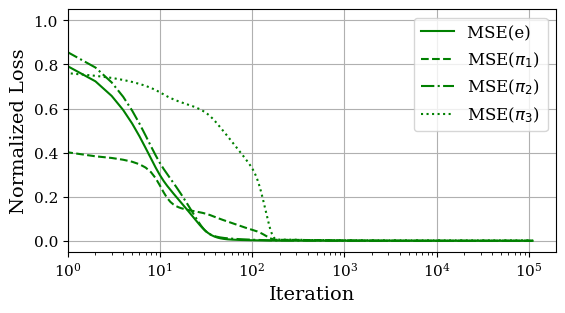

In [16]:
plt.figure(figsize=(width, height))

plt.plot(normalize_list(smooth_curve(train_e_loss_list)), label=r'MSE(e) ', color=training_curves_color, linestyle='-')
plt.plot(normalize_list(smooth_curve(train_pi1_loss_list)), label=r'MSE($\pi_1$) ', color=training_curves_color, linestyle='--')
plt.plot(normalize_list(smooth_curve(train_pi2_loss_list)), label=r'MSE($\pi_2$) ', color=training_curves_color, linestyle='-.')
plt.plot(normalize_list(smooth_curve(train_pi3_loss_list)), label=r'MSE($\pi_3$) ', color=training_curves_color, linestyle=':')

plt.xlabel('Iteration', fontsize=label_fontsize)
plt.ylabel('Normalized Loss', fontsize=label_fontsize)

plt.grid(True)
plt.legend(loc='upper right', fontsize=legend_fontsize)
plt.tick_params(axis='both', which='major', labelsize=tick_fontsize)
plt.xscale('log')
plt.xlim(left=1) 

plt.show()

Results validation

In [17]:
def relative_error_stats(validation, prediction, dx=x_step_size, dy=y_step_size):

    prediction_error = np.sqrt((np.trapz(np.trapz((validation - prediction)**2, dx=dy), dx=dx) /
                                np.trapz(np.trapz((validation)**2, dx=dy), dx=dx)))

    min = np.min(prediction_error)
    max = np.max(prediction_error)
    Q1 = np.percentile(prediction_error, 25)
    Q2 = np.percentile(prediction_error, 50)
    Q3 = np.percentile(prediction_error, 75)

    print(f"Min: {min:.2e}")
    print(f"Max: {max:.2e}")
    print(f"First quartile (Q1): {Q1:.2e}")
    print(f"Second quartile (Q2): {Q2:.2e}")
    print(f"Third quartile (Q3): {Q3:.2e}")

def absolute_error_stats(validation, prediction, dx=x_step_size, dy=y_step_size):
    prediction_error = np.sqrt(np.trapz(np.trapz((validation - prediction)**2, dx=dy), dx=dx))

    min = np.min(prediction_error)
    max = np.max(prediction_error)
    Q1 = np.percentile(prediction_error, 25)
    Q2 = np.percentile(prediction_error, 50)
    Q3 = np.percentile(prediction_error, 75)

    print(f"Min: {min:.2e}")
    print(f"Max: {max:.2e}")
    print(f"First quartile (Q1): {Q1:.2e}")
    print(f"Second quartile (Q2): {Q2:.2e}")
    print(f"Third quartile (Q3): {Q3:.2e}")

Solution $u(x, y)$

In [18]:
validation_solution = data['y_val']
predicted_solution = predictions_predictive_second_train
solution_diff = np.mean(np.abs(predicted_solution - validation_solution), axis=0)

relative_error_stats(validation=validation_solution, prediction=predicted_solution)

Min: 4.14e-05
Max: 1.33e-03
First quartile (Q1): 4.71e-05
Second quartile (Q2): 5.11e-05
Third quartile (Q3): 5.99e-05


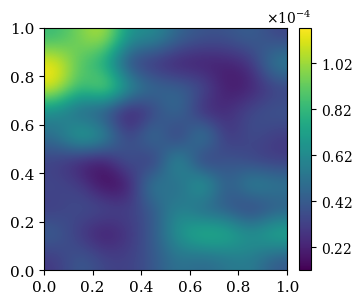

In [19]:
plt.figure(figsize=(height*1.2, height))

# Plot of the image
plt.imshow(solution_diff, interpolation='bicubic', extent=[0, 1, 0, 1])

# Colorbar and axis configuration
cbar = plt.colorbar(fraction=0.046, pad=0.04)
cbar.formatter = ScalarFormatter(useMathText=True)
cbar.formatter.set_powerlimits((0, 0))
cbar.update_ticks()
ticks = cbar.get_ticks()
new_ticks = (ticks + ticks[1]/10)
cbar.set_ticks(new_ticks[1:-1])

# Other parameters
plt.tick_params(axis='both', which='major', labelsize=tick_fontsize)
plt.tight_layout()

# Show the image
plt.show()

Diffusivity $K(u)$

In [20]:
validation_K = My(Mx(tf.convert_to_tensor(data['k_val'], dtype=tf.float32)))
predicted_K = predictions_explanatory_second_train
K_diff = np.mean(np.abs(predicted_K - validation_K), axis=0)

relative_error_stats(validation=validation_K, prediction=predicted_K)

Min: 9.69e-03
Max: 3.09e-01
First quartile (Q1): 1.79e-02
Second quartile (Q2): 4.63e-02
Third quartile (Q3): 5.87e-02


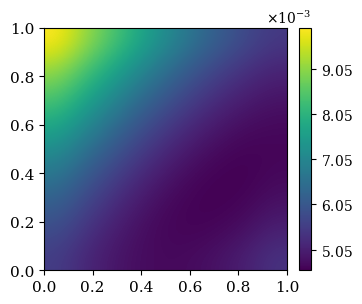

In [21]:
plt.figure(figsize=(height*1.2, height))

# Plot of the image
plt.imshow(K_diff, interpolation='bicubic', extent=[0, 1, 0, 1])

# Colorbar and axis configuration
cbar = plt.colorbar(fraction=0.046, pad=0.04)
cbar.formatter = ScalarFormatter(useMathText=True)
cbar.formatter.set_powerlimits((0, 0))
cbar.update_ticks()
ticks = cbar.get_ticks()
new_ticks = (ticks + 0.00005)
cbar.set_ticks(new_ticks[1:-1])

# Other parameters
plt.tick_params(axis='both', which='major', labelsize=tick_fontsize)
plt.tight_layout()

# Show the image
plt.show()

Flux $q_x$

In [22]:
validation_qx = My(Mx(tf.convert_to_tensor(data['qx_val'], dtype=tf.float32)))
predicted_qx = predicted_K*Dx(predictions_predictive_second_train).numpy()
qx_diff = np.mean(np.abs(predicted_qx - validation_qx), axis=0)

relative_error_stats(validation=validation_qx, prediction=predicted_qx)

Min: 1.06e-02
Max: 1.24e+00
First quartile (Q1): 2.05e-02
Second quartile (Q2): 4.64e-02
Third quartile (Q3): 5.38e-02


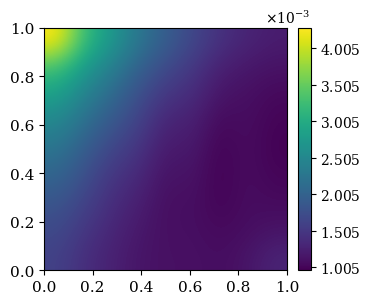

In [23]:
plt.figure(figsize=(height*1.2, height))

# Plot of the image
plt.imshow(qx_diff, interpolation='bicubic', extent=[0, 1, 0, 1])

# Colorbar and axis configuration
cbar = plt.colorbar(fraction=0.046, pad=0.04)
cbar.formatter = ScalarFormatter(useMathText=True)
cbar.formatter.set_powerlimits((0, 0))
cbar.update_ticks()
ticks = cbar.get_ticks()
new_ticks = (ticks + 0.000005)
cbar.set_ticks(new_ticks[1:-1])

# Other parameters
plt.tick_params(axis='both', which='major', labelsize=tick_fontsize)
plt.tight_layout()

# Show the image
plt.show()

Flux $q_y$

In [24]:
validation_qy = My(Mx(tf.convert_to_tensor(data['qy_val'], dtype=tf.float32)))
predicted_qy = predicted_K*Dy(predictions_predictive_second_train).numpy()
qy_diff = np.mean(np.abs(predicted_qy - validation_qy), axis=0)

relative_error_stats(validation=validation_qy, prediction=predicted_qy)

Min: 1.15e-02
Max: 7.09e+00
First quartile (Q1): 2.14e-02
Second quartile (Q2): 4.64e-02
Third quartile (Q3): 5.39e-02


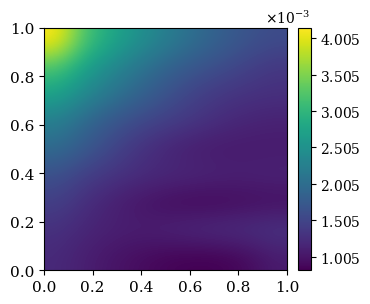

In [25]:
plt.figure(figsize=(height*1.2, height))

# Plot of the image
plt.imshow(qy_diff, interpolation='bicubic', extent=[0, 1, 0, 1])

# Colorbar and axis configuration
cbar = plt.colorbar(fraction=0.046, pad=0.04)
cbar.formatter = ScalarFormatter(useMathText=True)
cbar.formatter.set_powerlimits((0, 0))
cbar.update_ticks()
ticks = cbar.get_ticks()
new_ticks = (ticks + 0.000005)
cbar.set_ticks(new_ticks[1:-1])

# Other parameters
plt.tick_params(axis='both', which='major', labelsize=tick_fontsize)
plt.tight_layout()

# Show the image
plt.show()

In [26]:
validation_solution_tensor = Mx(My(tf.convert_to_tensor(validation_solution, dtype=tf.float32)))
predicted_solution_tensor = Mx(My(tf.convert_to_tensor(predicted_solution, dtype=tf.float32)))

reshaped_validation_solution = tf.reshape(validation_solution_tensor, [validation_solution_tensor.shape[0], -1]).numpy()
reshaped_predicted_solution = tf.reshape(predicted_solution_tensor, [predicted_solution_tensor.shape[0], -1]).numpy()
reshaped_validation_K = tf.reshape(validation_K, [validation_K.shape[0], -1]).numpy()
reshaped_predicted_K = tf.reshape(predicted_K, [predicted_K.shape[0], -1]).numpy()

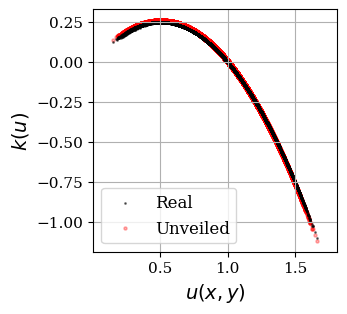

In [27]:
plt.figure(figsize=(height, height))

# Plot of the values
plt.scatter(reshaped_predicted_solution, reshaped_predicted_K, label='Unveiled', color='red', s=5, alpha=0.3)
plt.scatter(reshaped_validation_solution, reshaped_validation_K, label='Real', color='black', s=1, alpha=0.5)

# Labels configurations
plt.xlabel('$u(x, y)$', fontsize=label_fontsize)
plt.ylabel('$k(u)$', fontsize=label_fontsize)
plt.grid(True)

# Legend configuration
handles, labels = plt.gca().get_legend_handles_labels()
order = [1, 0] 
plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order], loc='lower left', fontsize=legend_fontsize)
plt.tick_params(axis='both', which='major', labelsize=tick_fontsize)

# Axis configurations
min = np.min(reshaped_validation_solution) - 0.1*(np.max(reshaped_validation_solution - np.min(reshaped_validation_solution)))
max = np.max(reshaped_validation_solution) + 0.1*(np.max(reshaped_validation_solution - np.min(reshaped_validation_solution)))
plt.xlim(min, max)

# Show the image
plt.show()

In [28]:
er = np.sqrt(np.sum(np.trapz(np.trapz((reshaped_predicted_K - reshaped_validation_K)**2, dx=x_step_size), dx=x_step_size))/np.sum(np.trapz(np.trapz((reshaped_validation_K)**2, dx=x_step_size), dx=x_step_size)))

print(f"er(K): {er:.2e}")

er(K): 3.28e-02


Predicted solutions

In [29]:
def calculate_error(validation_data, predicted_data):
    numerator = np.trapz(np.trapz((validation_data - predicted_data)**2))
    denominator = np.trapz(np.trapz((validation_data)**2))

    if np.all(denominator == 0):
        result = np.sqrt(numerator)
    else:
        result = np.sqrt(numerator / denominator)
    return result

def relative_error(validation, prediction):
    return (np.trapz(np.trapz((validation - prediction)**2))/np.trapz(np.trapz((validation)**2)))

solution


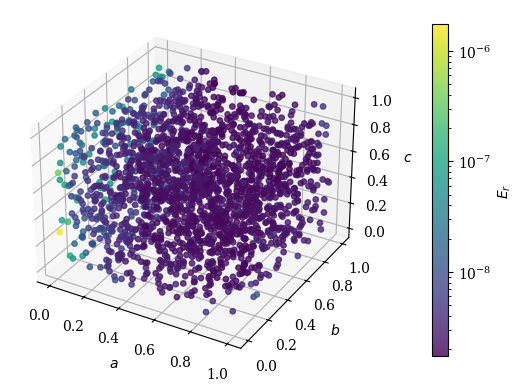

qx


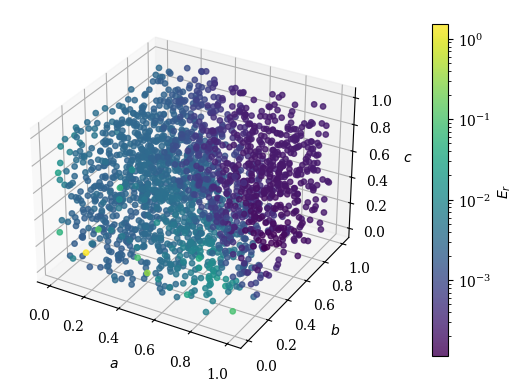

qy


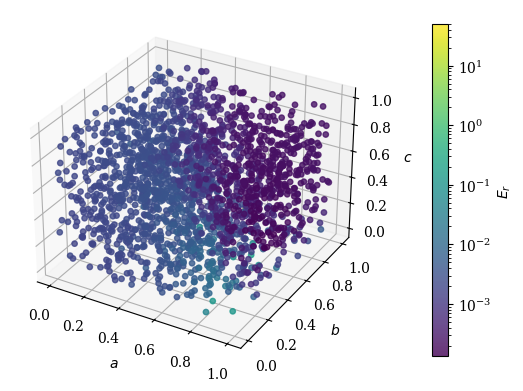

In [30]:
E_solution = relative_error(validation_solution, predicted_solution)
E_qx = relative_error(validation_qx, predicted_qx)
E_qy = relative_error(validation_qy, predicted_qy)

a = data['a_val']
b = data['b_val']
c = data['c_val']

def plot_error(a, b, c, error, variable):
    
    print(variable)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    sc = ax.scatter(a, b, c, c=error, cmap='viridis', s=15, alpha=0.8, norm=mcolors.LogNorm())
    cbar = plt.colorbar(sc, pad=0.12, shrink=0.9)
    cbar.set_label('$E_r$')

    ax.set_xlabel('$a$')
    ax.set_ylabel('$b$')
    ax.set_zlabel('$c$')

    plt.show()

plot_error(a=a, b=b, c=c, error=E_solution, variable='solution')
plot_error(a=a, b=b, c=c, error=E_qx, variable='qx')
plot_error(a=a, b=b, c=c, error=E_qy, variable='qy')